# Seq2Seq Encoder-Decoder Transformer

## Class Building

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import dataset


In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, causal=False):
        super().__init__()
        self.d_k = d_k
        self.n_heads = n_heads
        self.key = nn.Linear(d_model, d_k * n_heads)
        self.query = nn.Linear(d_model, d_k*n_heads)
        self.value = nn.Linear(d_model, d_k*n_heads)
        self.fc = nn.Linear(d_k * n_heads, d_model)

        self.causal = causal

        # Come il decoder se è causal, altrimenti no
        if causal:
            cm = torch.tril(torch.ones(max_len, max_len))
            self.register_buffer("causal_mask", cm.view(1, 1, max_len, max_len))


    def forward(self, q, k, v, pad_mask=None):
        q = self.query(q)
        k = self.key(k)
        v = self.value(v)

        N = q.shape[0]
        # Qui le cose cambiano un po': in un'architettura encoder-decoder, ad un certo punto ci sarò l'unione dell'encoder e del decoder e dovremo
        # modellare quali output del decoder devono prestare attenzione a determianati input dell'encoder
        # Nell'attention head del decoder, in particolare, arriveranno K e V da parte dell'encoder che si mixano con Q della causal attention
        # del decoder stesso. Per questo motivo, siccome non possiamo garantire che la lunghezza dell'input dell'encoder e quello del decoder 
        # siano uguali, dobbiamo definire l'output shape dell'encoder e del decoder separatamente.
        T_output = q.shape[1] # Lunghezza output del decoder
        T_input = k.shape[1] # Lunghezza input dell'enocoder (anche v andava bene)

        # Qui si riflettono i cambiamenti
        q = q.view(N, T_output, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)

        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
        if pad_mask is not None:
            attn_scores = attn_scores.masked_fill(pad_mask[:, None, None, :] == 0, float("-inf"))
        if self.causal:
            # Qui cambia anche la causal mask: ci sarà t_input e t_output (dimensione matrice cross attention)
            attn_scores = attn_scores.masked_fill(self.causal_mask[:, :, :T_output, :T_input] == 0, float("-inf"))
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        A = attn_weights @ v
        A = A.transpose(1, 2)
        # Qui la dimensione di uscita sarà sempre T_output
        A = A.contiguous().view(N, T_output, self.d_k * self.n_heads)
        
        return self.fc(A)

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(p=dropout_prob)
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, mask=None):
        x = self.ln1(x + self.mha(x, x, x, mask))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [4]:
class DecoderBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()
        
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)
        self.mha1 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=True)
        self.mha2 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(p=dropout_prob)
        )
        self.dropout = nn.Dropout(p=dropout_prob)
       
    
    def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
        # In primo luogo, prendiamo l'input del decoder e lo passiamo nella self attention del decoder
        x = self.ln1(dec_input + self.mha1(dec_input, dec_input, dec_input, dec_mask))

        # Ora applichiamo la cross attention
        x = self.ln2(x + self.mha1(x, enc_output, enc_output, enc_mask))

        # Infine FC e dropout
        x = self.ln3(x + self.ann(x))
        x = self.dropout(x)
        return x

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048, dropout_prob=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(max_len).unsqueeze(1)
        exp_term = torch.arange(0, d_model, 2) 
        div_term = torch.exp(exp_term * (- math.log(10000) / d_model))

        pe = torch.zeros(1, max_len, d_model)
        pe[0,:,0::2] = torch.sin(position * div_term) 
        pe[0,:,1::2] = torch.cos(position * div_term)

        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :] 
        return self.dropout(x)

In [6]:
"""
Questa classe subisce diverse modifiche. In primo luogo, siccome non stiamo solo codificando, le n_classes non ci servono più
Questo elimina di conseguenza anche la testa del modello, ovvero il classificatore.
"""
class Encoder(nn.Module):
    def __init__(self, vocab_size, max_len, d_k, d_model, n_heads, n_layers, dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformer_blocks = [EncoderBlock(d_k, d_model, n_heads, dropout_prob) for _ in range(n_layers)]
        self.transformers_blocks = nn.Sequential(*transformer_blocks)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.transformers_blocks:
            x = block(x, mask)

        # Altra modifica importante: qui ci serviranno tutti gli output, quindi non prendiamo più solo il primo "hidden layer"
        x = self.ln(x)
        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, max_len, d_k, d_model, n_heads, n_layers, dropout_prob):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformer_blocks = [DecoderBlock(d_k, d_model, n_heads, max_len, dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size) # Qui cambia rispetto all'encoder! Abbiamo bisogno della vocab size
        
    def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
        x = self.embedding(dec_input)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(enc_output, x, enc_mask, dec_mask)
            
        x = self.ln(x)
        x = self.fc(x) # many to many
        return x

#### Reminder di come funziona un Transformer Seq2Seq:

In primo luogo l'input passa per tutti gli EncoderBlocks. Quindi avremo il processing dell'encoder che produrrà dei vettori key, query e value,
ma solo dell'ultimo encoder!

Questi t_input vettori non vengono usati tutti. Solo K e V passano al decoder (come encoder_output), e questi vengono usati solamente nella mha2. Tuttavia, a differenza dell'encoder che lavora sempre "con i suoi input", il decoder prenderà in ingresso l'output della trafila dell'encoder autonomamente. Quindi l'output dell'encoder entra in ingresso ad ogni "DecoderBlock" del decoder.

In [8]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_input, dec_input, enc_mask, dec_mask):
        enc_output = encoder(enc_input, enc_mask)
        dec_output = decoder (enc_output, dec_input, enc_mask, dec_mask)
        return dec_output
        

### Testing 

In [9]:
encoder = Encoder(
    vocab_size=20000, 
    max_len=512,
    d_k=16,
    d_model=64, 
    n_layers=4,
    n_heads=2,
    dropout_prob=0.1             
)
decoder = Decoder(
    vocab_size=10000, 
    max_len=512,
    d_k=16,
    d_model=64, 
    n_layers=4,
    n_heads=2,
    dropout_prob=0.1  
)
model = Transformer(encoder, decoder)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
encoder.to(device);
decoder.to(device);

In [12]:
# Creiamo l'input dell'encoder randomicamente, con T = 512
xe = np.random.randint(0, 20000, size=(8, 512))
xe_t = torch.tensor(xe).to(device)

In [13]:
# Ora creiamo l'input del decoder randomicamente, ma lui con T = 256
xd = np.random.randint(0, 10000, size=(8, 256))
xd_t = torch.tensor(xd).to(device)

In [14]:
# Creiamo le relative maschere
maske = np.ones((8, 512))
maske[:, 256:] = 0
maske_t = torch.tensor(maske).to(device)

maskd = np.ones((8, 256))
maskd[:, 128:] = 0
maskd_t = torch.tensor(maskd).to(device)

In [15]:
out = model(xe_t, xd_t, maske_t, maskd_t)
out.shape

torch.Size([8, 256, 10000])

## Dataset

In [16]:
import os
from datasets import load_dataset
import pandas as pd

C:\Users\emili\Desktop\transformers_course\transformers-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
fpath = "spa.txt"
if not os.path.isfile(fpath):
    !curl -o "spa.txt" "https://lazyprogrammer.me/course_files/nlp3/spa.txt"

In [18]:
# Eng to spanish translation
df = pd.read_csv("spa.txt", sep="\t", header=None)
df.head()

,0,1
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Hi.,Hola.
4,Run!,¡Corre!


In [19]:
df = df.sample(30000).reset_index(drop=True) # Accorciamo o non finisce mai

In [20]:
df.head()

,0,1
0,It wasn't premeditated.,No fue premeditado.
1,Tom is thinking about applying for a better-pa...,Tom está pensando en postular a un trabajo que...
2,We'll talk about that later.,Conversaremos sobre eso después.
3,I think Tom is devious.,Creo que Tom es astuto.
4,They've fired him.,Lo despidieron.


In [21]:
df.columns = ["en", "es"]

In [22]:
df.to_csv("spa.csv", index=None)

In [23]:
raw_datasets = load_dataset("csv", data_files="spa.csv")
raw_datasets

Generating train split: 30000 examples [00:00, 529432.32 examples/s]


DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 30000
    })
})

In [24]:
split = raw_datasets["train"].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['en', 'es'],
        num_rows: 9000
    })
})

## Tokenizer & Data Collator 

In [25]:
from transformers import AutoTokenizer, DataCollatorForSeq2Seq

In [26]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

C:\Users\emili\Desktop\transformers_course\transformers-env\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
C:\Users\emili\Desktop\transformers_course\transformers-env\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
en_sentence = split["train"][0]["en"]
es_sentence = split["train"][0]["es"]

inputs = tokenizer(en_sentence)
targets = tokenizer(text_target=es_sentence)

# NB: Ci manca il token di padding all'inizio per il target. Questo non va bene per decoder, risolveremo dopo
tokenizer.convert_ids_to_tokens(targets["input_ids"]), es_sentence

(['▁Es', '▁difícil', '▁creer', '▁lo', '▁que', '▁dices', '.', '</s>'],
 'Es difícil creer lo que dices.')

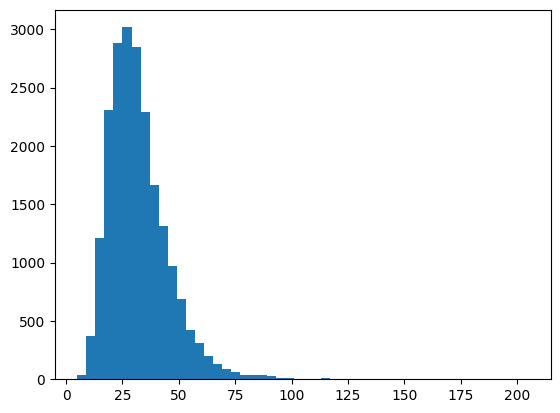

In [28]:
en_lens = [len(t["en"]) for t in split["train"]]
plt.hist(en_lens, bins=50);

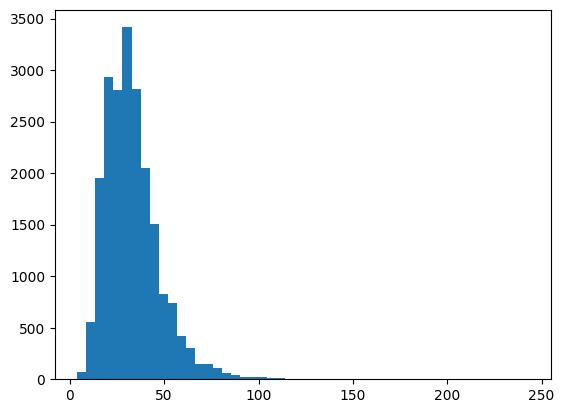

In [29]:
es_lens = [len(t["es"]) for t in split["train"]]
plt.hist(es_lens, bins=50);

In [30]:
# Possiamo usare tranquillamente una sequence lenght di 128 per entrambi
max_input_length = 128
max_output_length = 128

In [31]:
def preprocess_function(batch):
    model_inputs = tokenizer(batch["en"], max_length=max_input_length, truncation=True)
    labels = tokenizer(batch["es"], max_length=max_output_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [32]:
tokenized_datasets = split.map(preprocess_function, batched=True, remove_columns=split["train"].column_names)

Map: 100%|███████████████████████████████████████████████████████████████| 9000/9000 [00:00<00:00, 15996.97 examples/s]


In [33]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9000
    })
})

In [34]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

In [35]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(5)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [36]:
# NB: pad tokens non sono 0 ma 65k
batch["input_ids"]

tensor([[   94,    31,  2445,    13,  1232,   150,    40,   560,     3,     0,
         65000, 65000, 65000],
        [ 2760,   138,  4289,     5,   398,    53, 17756,     3,     0, 65000,
         65000, 65000, 65000],
        [   33,   325,    13,   634,   120,   174,  5266,    59,    73,  1358,
          1101,     3,     0],
        [  124,   172,  9103,    16,     5, 11367,     3,     0, 65000, 65000,
         65000, 65000, 65000],
        [ 1675,    40,   105,     7,  5266,    20,     9, 14506,    21,     0,
         65000, 65000, 65000]])

In [37]:
# Riprova che 65k è il pad
batch["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])

In [38]:
# Il pad del target è diverso!! E' -100
batch["labels"]

tensor([[  177,  1162,   698,  1560,  9731,  8770,   237,    57,    15,    25,
         15849,     9,     3,     0,  -100,  -100,  -100,  -100,  -100,  -100],
        [   69, 13584,   203,    15,    15,  9763, 17109,     6,    25,  2785,
            43,  8753,  4862,  1754,     3,     0,  -100,  -100,  -100,  -100],
        [ 7511,  2367,   730, 36009,  4565,    91,   122,  5266,    87,    25,
          3883,  6235,   151,     8,     6,    25, 36009,  7203,     3,     0],
        [   71,     9, 12174,  4190,  4564,  7697,    12,    14,    25,  6574,
           487,  4683,     3,     0,  -100,  -100,  -100,  -100,  -100,  -100],
        [   25,  7287,   490,   100,     9,    28,    97,     4,    17,  2564,
          6323,     9,     4,  5266,    21,     0,  -100,  -100,  -100,  -100]])

In [39]:
# 0 -> End of sentence, 65k -> PAD, 1 -> ??
tokenizer.all_special_ids

[0, 1, 65000]

In [40]:
# 1 corrisponde all'unkown token!!
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>']

In [41]:
# Un tokenizer mette sempre uno 0 a qualsiasi cosa passiamo. Questo ci potrà essere sia utile che di intralcio
# Facciamo un esempio passando un pad
tokenizer("<pad>")

{'input_ids': [65000, 0], 'attention_mask': [1, 1]}

## Training

### Data Loader

In [42]:
from torch.utils.data import DataLoader

In [43]:
train_loader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)

In [44]:
valid_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=32,
    collate_fn=data_collator
)

In [45]:
# Vediamo cosa fa
for batch in train_loader:
    for k, v in batch.items():
        print("key:", k, "value shape:", v.shape)
    break

key: input_ids value shape: torch.Size([32, 14])
key: attention_mask value shape: torch.Size([32, 14])
key: labels value shape: torch.Size([32, 25])


In [46]:
tokenizer.vocab_size

65001

In [47]:
# Il tokenizer, tuttavia, sembra non avere il token "start of sentence": <s>, quindi glielo mettiamo noi
# Stiamo praticamente creando il CLS token di bert, usando <s> come token
# Come sappiamo che manca il CLS? Beh, abbiamo esplorato prima gli special token e vi era solo end of sentence, unknown e padding
# possiamo usare 
tokenizer.add_special_tokens({"cls_token": "<s>"})

1

In [48]:
tokenizer("<s>")

{'input_ids': [65001, 0], 'attention_mask': [1, 1]}

In [49]:
# Nonostante l'operazione, pare che la vocab size non sia cambiata, quindi dovremmo aggiornarla noi manualmente
tokenizer.vocab_size

65001

In [50]:
# Però adesso notiamo che effettivamente abbiamo uno special id.
tokenizer.all_special_ids

[0, 1, 65000, 65001]

### Model Building 

In [51]:
encoder = Encoder(
    vocab_size=tokenizer.vocab_size+1, 
    max_len=512,
    d_k=16,
    d_model=64, 
    n_layers=4,
    n_heads=2,
    dropout_prob=0.1             
)
decoder = Decoder(
    vocab_size=tokenizer.vocab_size+1, 
    max_len=512,
    d_k=16,
    d_model=64, 
    n_layers=4,
    n_heads=2,
    dropout_prob=0.1  
)
transformer = Transformer(encoder, decoder)

In [52]:
# Perchè nel corso non mette direttamente il transformer nel device?
encoder.to(device)
decoder.to(device)
transformer.to(device)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(65002, 64)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformers_blocks): Sequential(
      (0): EncoderBlock(
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mha): MultiHeadAttention(
          (key): Linear(in_features=64, out_features=32, bias=True)
          (query): Linear(in_features=64, out_features=32, bias=True)
          (value): Linear(in_features=64, out_features=32, bias=True)
          (fc): Linear(in_features=32, out_features=64, bias=True)
        )
        (ann): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
 

### Loss e Optimizer

In [53]:
# Qui gli diciamo quale criterio usiamo per la loss. Diciamo di ignorare l'indice -100 che è quello del padding
# ATTENZIONE. Il -100 è quello delle labels! Noi è sulle label che vogliamo ignorare
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(transformer.parameters())

### Training Function

In [54]:
from datetime import datetime

In [55]:
def training_step(data_loader, model, criterion, optimizer):
    batch_loss = []
    for batch in data_loader:
        batch = {k: v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        enc_inputs = batch["input_ids"]
        enc_mask = batch["attention_mask"]
        targets = batch["labels"]

        # Shiftiamo i target avanti per avere l'input del decoder. E' come se pushassimo le parole verso destra
        # Infine, inseriamo a prima posizione il nostro "start_token"
        dec_inputs = targets.clone().detach()
        dec_inputs = torch.roll(dec_inputs, shifts=1, dims=1)
        dec_inputs[:, 0] = 65001

        # Convertiamo tutti i pad token che sono -100 in pad token di tokenizer, ovvero 65k)
        dec_inputs = dec_inputs.masked_fill(dec_inputs==-100, tokenizer.pad_token_id)

        # Creiamo la decoder mask
        dec_mask = torch.ones_like(dec_inputs)
        dec_mask = dec_mask.masked_fill(dec_inputs==tokenizer.pad_token_id, 0)

        # Facciamo il forward pass
        outputs = model(enc_inputs, dec_inputs, enc_mask, dec_mask)
        # Ricordiamo questo passaggio: lui ritornerà una determianta dimensione (Batch x T x Vocab_size) ma a noi serve avere la vocab size come
        # seconda dimensione, quindi lo trasponiamo
        loss = criterion(outputs.transpose(2, 1), targets)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    return np.mean(batch_loss)
    

In [56]:
def train(model, criterion, optimizer, train_loader, valid_loader, n_epochs):
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for it in range(n_epochs):
        model.train()
        d0 = datetime.now()
        train_loss = training_step(train_loader, model, criterion, optimizer)
        train_losses[it] = train_loss

        model.eval()
        valid_loss = training_step(valid_loader, model, criterion, optimizer)
        valid_losses[it] = valid_loss

        dt = datetime.now() - d0
        print(f"Epoch: {it+1}/{n_epochs} --- Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Duration: {dt}")
    return train_losses, valid_losses   

In [59]:
def train(model, criterion, optimizer, train_loader, valid_loader, n_epochs):
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for it in range(n_epochs):
        model.train()
        t0 = datetime.now()
        batch_train_loss = []
        for batch in train_loader:
            batch = {k: v.to(device) for k,v in batch.items()}
            optimizer.zero_grad()
            enc_inputs = batch["input_ids"]
            enc_mask = batch["attention_mask"]
            targets = batch["labels"]

            # Shiftiamo i target avanti per avere l'input del decoder. E' come se pushassimo le parole verso destra
            # Infine, inseriamo a prima posizione il nostro "start_token"
            dec_inputs = targets.clone().detach()
            dec_inputs = torch.roll(dec_inputs, shifts=1, dims=1)
            dec_inputs[:, 0] = 65001

            # Convertiamo tutti i pad token che sono -100 in pad token di tokenizer, ovvero 65k)
            dec_inputs = dec_inputs.masked_fill(dec_inputs==-100, tokenizer.pad_token_id)

            # Creiamo la decoder mask
            dec_mask = torch.ones_like(dec_inputs)
            dec_mask = dec_mask.masked_fill(dec_inputs==tokenizer.pad_token_id, 0)

            # Facciamo il forward pass
            outputs = model(enc_inputs, dec_inputs, enc_mask, dec_mask)
            # Ricordiamo questo passaggio: lui ritornerà una determianta dimensione (Batch x T x Vocab_size) ma a noi serve avere la vocab size come
            # seconda dimensione, quindi lo trasponiamo
            loss = criterion(outputs.transpose(2, 1), targets)

            loss.backward()
            optimizer.step()
            batch_train_loss.append(loss.item())
            
        train_loss = np.mean(batch_train_loss)
        train_losses[it] = train_loss

        model.eval()
        batch_valid_loss = []
        for batch in valid_loader:
            batch = {k: v.to(device) for k,v in batch.items()}
            optimizer.zero_grad()
            enc_inputs = batch["input_ids"]
            enc_mask = batch["attention_mask"]
            targets = batch["labels"]

            # Shiftiamo i target avanti per avere l'input del decoder. E' come se pushassimo le parole verso destra
            # Infine, inseriamo a prima posizione il nostro "start_token"
            dec_inputs = targets.clone().detach()
            dec_inputs = torch.roll(dec_inputs, shifts=1, dims=1)
            dec_inputs[:, 0] = 65001

            # Convertiamo tutti i pad token che sono -100 in pad token di tokenizer, ovvero 65k)
            dec_inputs = dec_inputs.masked_fill(dec_inputs==-100, tokenizer.pad_token_id)

            # Creiamo la decoder mask
            dec_mask = torch.ones_like(dec_inputs)
            dec_mask = dec_mask.masked_fill(dec_inputs==tokenizer.pad_token_id, 0)

            # Facciamo il forward pass
            outputs = model(enc_inputs, dec_inputs, enc_mask, dec_mask)
            # Ricordiamo questo passaggio: lui ritornerà una determianta dimensione (Batch x T x Vocab_size) ma a noi serve avere la vocab size come
            # seconda dimensione, quindi lo trasponiamo
            loss = criterion(outputs.transpose(2, 1), targets)

            loss.backward()
            optimizer.step()
            batch_valid_loss.append(loss.item())
        
        valid_loss = np.mean(batch_valid_loss)
        valid_losses[it] = valid_loss

        dt = datetime.now() - t0
        print(f"Epoch: {it+1}/{n_epochs} --- Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Duration: {dt}")
    return train_losses, valid_losses     

In [60]:
train_losses, test_losses = train(transformer, criterion, optimizer, train_loader, valid_loader, n_epochs=2)

Epoch: 1/15 --- Train Loss: 3.7290, Valid Loss: 3.1734, Duration: 0:08:07.505014
Epoch: 2/15 --- Train Loss: 3.2574, Valid Loss: 2.7322, Duration: 0:08:10.575956


KeyboardInterrupt: 

## Inference

Per usare correttamente il modello, noi useremo encoder e decoder in maniera separata. Vorremmo calcolare prima il risultato dell'encoder, ovvero la codifica embedded della frase in inglese. Questa verrà successivamente inserita nel decoder per fare inferenza autoregressiva

In [140]:
transformer.eval();

In [123]:
sample = 11
input_sentence = split["test"][sample]["en"]
input_sentence

"Mary doesn't use salt in her cooking."

In [124]:
enc_input = tokenizer(input_sentence, return_tensors="pt")
enc_input

{'input_ids': tensor([[ 4963,  2088,    20,    56,   268, 11626,    16,   225, 15578,     3,
             0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [125]:
# Serve l'input del decoder. Siccome useremo il decoder in modalità generativa (inferene), noi avremo solamente l'input <s>
# ignoreremo il secondo token
dec_input_str = "<s>"
dec_input = tokenizer(text_target=dec_input_str, return_tensors="pt")
dec_input

{'input_ids': tensor([[65001,     0]]), 'attention_mask': tensor([[1, 1]])}

In [126]:
enc_input.to(device)
dec_input.to(device)

{'input_ids': tensor([[65001,     0]], device='cuda:0'), 'attention_mask': tensor([[1, 1]], device='cuda:0')}

In [127]:
output = transformer(
    enc_input["input_ids"],
    dec_input["input_ids"][:,:-1],
    enc_input["attention_mask"],
    dec_input["attention_mask"][:,:-1]
)
output

tensor([[[ 4.2466, -4.5174,  2.2848,  ..., -6.8810, -7.8362, -7.3809]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [128]:
output.shape

torch.Size([1, 1, 65002])

In [129]:
enc_output = encoder(enc_input["input_ids"], enc_input["attention_mask"])
enc_output.shape

torch.Size([1, 11, 64])

In [130]:
dec_output = decoder(
    enc_output,
    dec_input["input_ids"][:,:-1],
    enc_input["attention_mask"],
    dec_input["attention_mask"][:,:-1]
)
dec_output

tensor([[[ 4.2466, -4.5174,  2.2848,  ..., -6.8810, -7.8362, -7.3809]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [131]:
dec_output.shape

torch.Size([1, 1, 65002])

In [132]:
# Questo è un sanity check: se usiamo prima encoder e decoder e poi usiamo l'intero transformer, abbiamo lo stesso risultato?
torch.allclose(output, dec_output)

True

In [136]:
# Loop Autoregressivo
dec_input_ids = dec_input["input_ids"][:,:-1]
dec_attn_mask = dec_input["attention_mask"][:,:-1]

for _ in range(100):
    dec_output = decoder(
        enc_output,
        dec_input_ids,
        enc_input["attention_mask"],
        dec_attn_mask
    )

    # Prendiamo il token più probabile (o campioniamo con softmax) sull'ultimo token del decoder (ultimo timestep), maxando sulla dimensione vocab
    prediction_id = torch.argmax(dec_output[:,-1,:], axis=-1)

    # Appendiamo il token predetto e aggiorniamo la mask del decoder
    # print(prediction_id.shape) -> questo ci da un tensore di size (1, ). A noi serve bidimensionale
    dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1,1)))
    dec_attn_mask = torch.ones_like(dec_input_ids)

    # Se troviamo il </s> finale, interrompiamo
    if prediction_id == 0:
        break

In [138]:
dec_input_ids

tensor([[65001,  4963,    37,    26,    25,   210, 14943,    12,    45,    25,
           210, 10031,     3,     0]], device='cuda:0')

In [139]:
tokenizer.decode(dec_input_ids[0])

'<s> Mary no se llega en su llave.</s>'

In [141]:
output_real = split["test"][sample]["es"]
output_real

'Mary cocina sin sal.'

In [159]:
def translate(input_sentence):
    
    enc_input = tokenizer(input_sentence, return_tensors="pt").to(device)
    enc_output = encoder(enc_input["input_ids"], enc_input["attention_mask"])

    dec_input_str = "<s>"
    dec_input = tokenizer(text_target=dec_input_str, return_tensors="pt").to(device)
    dec_input_ids = dec_input["input_ids"][:,:-1]
    dec_attn_mask = torch.ones_like(dec_input_ids)

    for _ in range(100):
        dec_output = decoder(
            enc_output,
            dec_input_ids,
            enc_input["attention_mask"],
            dec_attn_mask
        )
    
        # Prendiamo il token più probabile (o campioniamo con softmax) sull'ultimo token del decoder (ultimo timestep), maxando sulla dimensione vocab
        prediction_id = torch.argmax(dec_output[:,-1,:], axis=-1)
    
        # Appendiamo il token predetto e aggiorniamo la mask del decoder
        # print(prediction_id.shape) -> questo ci da un tensore di size (1, ). A noi serve bidimensionale
        dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1,1)))
        dec_attn_mask = torch.ones_like(dec_input_ids)
    
        # Se troviamo il </s> finale, interrompiamo
        if prediction_id == 0:
            break
            
    print(tokenizer.decode(dec_input_ids[0]))

In [160]:
translate("If you think you are correct, do so, and you will never be wrong")

<s> Si te qué es más, no es más, no es más.</s>
